## Network Monitoring

***Stage 0: Import Libraries***
In this code block we are going to import all the python libraries that we are going to use.

In [1]:
import io, os, sys, types, datetime, math, time, glob
from datetime import datetime, timedelta

import splunklib.client as client
import splunklib.results as results
import pandas as pd
import numpy as np

import networkx as nx

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt 
%matplotlib inline

***Stage 1: Connect to Splunk***

Here we are going to set up our connect to Splunk. Note that you will need to change the host, port, username and password to match your environment. 

In [2]:
HOST = "localhost"
PORT = 8089
USERNAME = "user"
PASSWORD = "password"

# Create a Service instance and log in 
service = client.connect(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD)

Next up we are querying our Splunk instance to return the CIDDS data (https://www.hs-coburg.de/forschung/forschungsprojekte-oeffentlich/informationstechnologie/cidds-coburg-intrusion-detection-data-sets.html#:~:text=CIDDS%20(Coburg%20Intrusion%20Detection%20Data,penetrate%20their%20target%20of%20interest.). Note that you will need to download and import netflow data from the CIDDS-001 dataset into an index called cidds in order for the query below to work properly. 

In [3]:
# Run an export search and display the results using the results reader.
kwargs_export = {"earliest_time": "0",
                 "latest_time": "now",
                 "enable_lookups": "true",
                 "parse_only": "false",
                 "count": "0"}
searchquery_export = 'search index=cidds "Src IP Addr"=192.168.* "Dst IP Addr"=192.168.* earliest=0 | stats count by "Src IP Addr" "Dst IP Addr"'

exportsearch_results = service.jobs.oneshot(searchquery_export, **kwargs_export)

# Get the results and display them using the ResultsReader
reader = results.ResultsReader(exportsearch_results)

items=[]
for item in reader:
    items.append(item)

df=pd.DataFrame(items)

***Stage 2: Analyse our Netflow logs to understand the Topology of the Network***

Here we are using the NetworkX library to visualise the network and also to identify the most embedded - i.e. those with the most connections - nodes in the network.

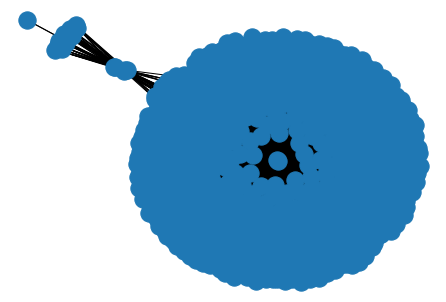

In [4]:
graph = nx.Graph()

for index, row in df.iterrows():
    graph.add_edge(row['Src IP Addr'], row['Dst IP Addr'], value=row['count'])

nx.draw(graph)                                          

We are then going to calculate some centrality measures that will help identify the most embedded nodes in the network by measuing the degrees of connectedness across the network structre we have visualised above.

In [5]:
# compute centrality
outputcolumns = []
cents = nx.algorithms.centrality.degree_centrality(graph)
degs = pd.DataFrame(list(cents.items()), columns=['Src IP Addr', 'degree_centrality'])
                                          
cents = nx.algorithms.centrality.eigenvector_centrality(graph, max_iter=1000)
eigen = pd.DataFrame(list(cents.items()), columns=['Src IP Addr', 'eigenvector_centrality'])

In [6]:
degs.sort_values(['degree_centrality'],ascending=0).head(5)

,Src IP Addr,degree_centrality
2,192.168.220.15,0.983418
3,192.168.220.16,0.983418
1,192.168.100.5,0.028061
6,192.168.100.4,0.026786
7,192.168.100.6,0.026786


In [7]:
eigen.sort_values(['eigenvector_centrality'],ascending=0).head(5)

,Src IP Addr,eigenvector_centrality
2,192.168.220.15,0.499440
3,192.168.220.16,0.499440
1,192.168.100.5,0.033055
6,192.168.100.4,0.032388
7,192.168.100.6,0.032388


***Stage 3: Identify Anomalies***

Next up we are going to use look for anomalies in our network data.

Firtly we are going to run another search against our Splunk data to return the number of flows across a given IP address - in this case the IP 192.168.220.15 that we identified using graph analytics above as being embedded in our network.

In [8]:
# Run an export search and display the results using the results reader.
kwargs_export = {"earliest_time": "0",
                 "latest_time": "now",
                 "enable_lookups": "true",
                 "parse_only": "false",
                 "count": "0"}
searchquery_export = '| tstats count as flows WHERE index=cidds "Src IP Addr"=192.168.220.15 BY _time span=1h | eval DayOfWeek=strftime(_time,"%w")'

exportsearch_results = service.jobs.oneshot(searchquery_export, **kwargs_export)

# Get the results and display them using the ResultsReader
reader = results.ResultsReader(exportsearch_results)

items=[]
for item in reader:
    items.append(item)

df_192_168_220_15=pd.DataFrame(items)
df_192_168_220_15['count_flows']=df_192_168_220_15['flows'].astype(float)

Now that we have the data we are going to look for anomalies using the isolation forest algorithm, using the number of flows and the day of the week as the features to baseline what is 'normal' for this data.

In [9]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df_192_168_220_15[['DayOfWeek','count_flows']])

IsolationForest(contamination=0.12, n_jobs=-1, random_state=42)

With our trained isolation forest model we are now looking for the specific occurences in the data that represent an outlier.

In [10]:
pred = clf.predict(df_192_168_220_15[['DayOfWeek','count_flows']])
df_192_168_220_15['anomaly']=pred

def transform_row(x):
    output=None
    if x['anomaly']==-1:
        output=x['count_flows']
    return output

df_192_168_220_15['outlier']=df_192_168_220_15.apply(transform_row, axis=1)

We're now going to plot our raw data and the anomalies on a line chart to visually identify where any outliers occur in the data.

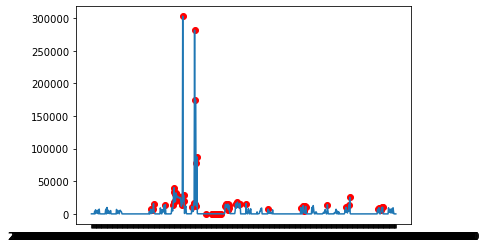

In [11]:
plt.scatter(df_192_168_220_15['_time'],df_192_168_220_15['outlier'],color='red')
plt.plot(df_192_168_220_15['_time'], df_192_168_220_15['count_flows'])
plt.show()